# Setup


In [9]:
!pip install datasets --quiet
!pip install transformers --quiet
!pip install nltk --quiet
!pip install rouge_score --quiet

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/UC3M/CUARTO/CS577 - NLP/FINAL'
path = '/content/drive/MyDrive/FINAL'

Mounted at /content/drive


In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Data

In [4]:
import pandas as pd

df = pd.read_csv(f'{path}/data/reviews.csv', index_col=0)
df.head()

,score,summary,text
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,5,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
from datasets import Dataset, load_metric

raw_data = Dataset.from_pandas(df)
split_data = raw_data.train_test_split(test_size=0.2)

metric = load_metric('rouge')

In [6]:
from transformers import AutoTokenizer

model_checkpoint = 't5-small'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

In [7]:
max_input_length = 1024
max_target_length = 128
prefix = "summarize: " if model_checkpoint in ["t5-small", "t5-base", "t5-larg", "t5-3b", "t5-11b"] else ""

def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["text"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summary"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [8]:
tokenized_data = split_data.map(preprocess_function, batched=True)

  0%|          | 0/40 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

# Model

In [11]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

In [12]:
import nltk
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    
    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}

In [13]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

batch_size = 8
model_name = model_checkpoint.split("/")[-1]

args = Seq2SeqTrainingArguments(
    output_dir = f"{path}/models/{model_name}",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_steps = 5000,
    save_total_limit=10,
    overwrite_output_dir=True,
    num_train_epochs=10,
    predict_with_generate=True,
    fp16=True,
)

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Using amp half precision backend


In [ ]:
trainer.train()

# Evalutation

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

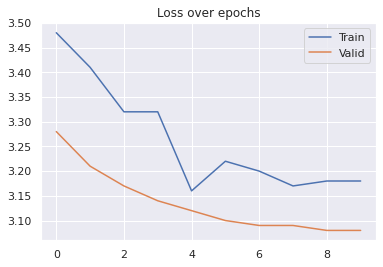

In [ ]:
train_loss = [3.48, 3.41, 3.32, 3.32, 3.16, 3.22, 3.20, 3.17, 3.18, 3.18]
valid_loss = [3.28, 3.21, 3.17, 3.14, 3.12, 3.10, 3.09, 3.09, 3.08, 3.08]
axis = np.arange(10)

plt.figure()
plt.plot(axis, train_loss, label='Train')
plt.plot(axis, valid_loss, label='Valid')
plt.legend()
plt.title('Loss over epochs')
plt.savefig(f'{path}/images/transformer_loss.png')
plt.show()

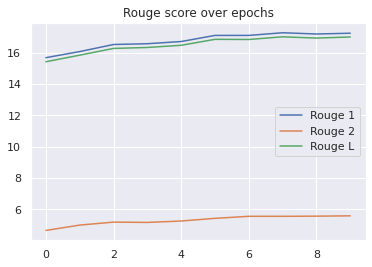

In [ ]:
rouge_1 = [15.68, 16.07, 16.52, 16.57, 16.71, 17.10, 17.10, 17.27, 17.19, 17.24]
rouge_2 = [04.66, 05.00, 05.19, 05.17, 05.26, 05.43, 05.56, 05.56, 05.57, 05.59]
rouge_l = [15.42, 15.84, 16.27, 16.33, 16.47, 16.85, 16.84, 17.01, 16.93, 17.00]

plt.figure()
plt.plot(axis, rouge_1, label='Rouge 1')
plt.plot(axis, rouge_2, label='Rouge 2')
plt.plot(axis, rouge_l, label='Rouge L')
plt.legend()
plt.title('Rouge score over epochs')
plt.savefig(f'{path}/images/transformer_metrics.png')
plt.show()

# Test

In [15]:
checkpoint = 50000
model = AutoModelForSeq2SeqLM.from_pretrained(f'{path}/models/{model_checkpoint}/checkpoint-{checkpoint}')

loading configuration file /content/drive/MyDrive/FINAL/models/t5-small/checkpoint-50000/config.json
Model config T5Config {
  "_name_or_path": "/content/drive/MyDrive/FINAL/models/t5-small/checkpoint-50000",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
   

In [16]:
def generate_summary(instance):
    input_ids = tokenizer(instance, max_length=max_input_length, truncation=True, return_tensors="pt").input_ids
    outputs = model.generate(input_ids=input_ids, max_length=20, top_k=30, do_sample=True)
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

In [21]:
raw_data['summary'][:5]

['Good Quality Dog Food',
 'Not as Advertised',
 '"Delight" says it all',
 'Cough Medicine',
 'Great taffy']

In [22]:
summaries = []
for instance in raw_data['text'][:5]: summaries.append(generate_summary(f'{prefix}{instance}'))
summaries

['Great product',
 'Jumbo Salted Peanuts - I had this!',
 'The most flavorful treat',
 'Best product in the industry',
 'great taffy']

In [ ]:
summaries = []
for instance in raw_data['text']: summaries.append(generate_summary(f'{prefix}{instance}'))

df['generate_summary'] = summaries
df['generate_summary'] = df['generated_summary'].values.astype('U')
df.to_csv(f'{path}/data/reviews_generated.csv')